In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openpyxl
import datetime
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
# Transforming into array
exog = np.array(exog)
exogForecast = np.array(exogForecast)

model = sm.tsa.UnobservedComponents(demand_ts, exog=exog).fit(disp=False)

out = np.concatenate([model.get_prediction(start=demand_ts.index.min(),end=demand_ts.index.max(), exog=exog).summary_frame()['mean'].values,
                                  model.forecast(steps=horizon, exog=exogForecast).values])

In [3]:
def create_date_range(start_date, end_date, freq): 
  return pd.date_range(
    start = start_date,
    end = end_date + pd.DateOffset(weeks=1),
    freq='1M') - freq

  

def create_time_series(data_frame, start_date, end_date, var, freq):
  # time series
  time_series = pd.Series(
      data = data_frame[var].values,
      index = pd.date_range(start = start_date, end = end_date, freq = freq)
    )

  return(time_series)


##  Converter o dataframe em uma serie temporal mensal
def case_treatment(data, freq): 
  start_date = data['date'].min()
  end_date = data['date'].max()  
  date_range = create_date_range(start_date, end_date, freq=freq)
  data_aux = pd.DataFrame({'date': date_range })

  data = pd.merge(data_aux, data, on='date', how='left')

  data = data.set_index(["date"], drop=True)  
  data.interpolate(method='linear', inplace=True)

  time_series = create_time_series(data, start_date, end_date, var="price", freq=freq)
  return time_series

  ##  Converter o dataframe em uma serie temporal mensal
def case_treatment_week(data, freq): 
  start_date = data['date'].min()
  end_date = data['date'].max()  
  date_range = create_date_range(start_date, end_date, freq=pd.offsets.MonthBegin(1))
  data_aux = pd.DataFrame({'date': date_range })

  data = pd.merge(data_aux, data, on='date', how='left')

  data = data.set_index(["date"], drop=True)  
  data.interpolate(method='linear', inplace=True)

  time_series = create_time_series(data, start_date, end_date, var="price", freq=pd.offsets.Week(1))
  return time_series

In [8]:
database = database[ 
  (database['product'] == "GASOLINA COMUM")]

database = database[database['region']  == "SUDESTE"]

start_date = database['date'].min()
end_date = database['date'].max()  
date_range = pd.date_range(
    start = start_date + pd.DateOffset(weeks=1),
    end = end_date + pd.DateOffset(weeks=1),
    freq='W') - pd.offsets.Week(1)
date_range

data_aux = pd.DataFrame({'date': date_range })
data = pd.merge(data_aux, database, on='date', how='left')
data = data.set_index(["date"], drop=True)  
data.interpolate(method='linear', inplace=True)
time_series = create_time_series(data, start_date, end_date, var="price", freq=pd.offsets.Week(1))



In [6]:
time_series.to_excel('gasolina_week.xlsx')

In [9]:
petroleo = pd.read_csv('Petróleo Brent Futuros Dados Históricos.csv')

In [10]:
petroleo['Data'] = pd.to_datetime(petroleo['Data'], format='%d.%m.%Y')

In [11]:
petroleo = petroleo.sort_values(by='Data')

In [17]:
petroleo['Último'] = petroleo['Último'].str.replace(',', '.').astype(float)

In [20]:
exog = petroleo['Último']

In [21]:
exog

487    111.31
486    110.64
485    111.89
484    113.28
483    116.76
        ...  
4      102.78
3      111.70
2      106.65
1      109.34
0      112.39
Name: Último, Length: 488, dtype: float64

In [4]:
##  Separar por regiões e cada tipo de gasolina dentro de um dicionario. 
#   Exemplo de acesso a serie db['NORTE']['GASOLINA COMUM'];
def handler_database(database, freq): 
  db = {}
  for region in database['region'].unique():
    db[region] = {}
    for product in database['product'].unique():
      aux = database[(database['region'] == region) & (database['product'] == product)]
      aux = aux.filter(['date', 'price'])
      db[region][product] = case_treatment(data=aux, freq=freq)
  return (db)

In [8]:
def load_database_mounth(): 
  filename = 'mensal-regioes-desde-jan2013.xlsx'
  #file_url = "https://www.gov.br/anp/pt-br/assuntos/precos-e-defesa-da-concorrencia/precos/precos-revenda-e-de-distribuicao-combustiveis/shlp/semanal/semanal-regioes-desde-2013.xlsx"
  database = pd.read_excel(filename, skiprows=16)
  ## Excluir colunas desnecessárias
  database = database.drop([
    'NÚMERO DE POSTOS PESQUISADOS', 
    'UNIDADE DE MEDIDA',
    'DESVIO PADRÃO REVENDA',
    'PREÇO MÍNIMO REVENDA',
    'PREÇO MÁXIMO REVENDA',
    'MARGEM MÉDIA REVENDA',
    'COEF DE VARIAÇÃO REVENDA',
    'PREÇO MÉDIO DISTRIBUIÇÃO',
    'DESVIO PADRÃO DISTRIBUIÇÃO',
    'PREÇO MÍNIMO DISTRIBUIÇÃO',
    'PREÇO MÁXIMO DISTRIBUIÇÃO',
    'COEF DE VARIAÇÃO DISTRIBUIÇÃO'],
    axis=1
  )
  ## Renomear colunas
  database = database.rename(columns={
      'MÊS': 'date',
      'REGIÃO': 'region',
      'PRODUTO': 'product',
      'PREÇO MÉDIO REVENDA': 'price'
  })

  return(database)

def load_database_week(): 
  filename = 'semanal-regioes-desde-2013.xlsx'
  #file_url = "https://www.gov.br/anp/pt-br/assuntos/precos-e-defesa-da-concorrencia/precos/precos-revenda-e-de-distribuicao-combustiveis/shlp/semanal/semanal-regioes-desde-2013.xlsx"
  database = pd.read_excel(filename, skiprows=17)
  ## Excluir colunas desnecessárias
  database = database.drop([
    'DATA FINAL',
    'NÚMERO DE POSTOS PESQUISADOS', 
    'UNIDADE DE MEDIDA',
    'DESVIO PADRÃO REVENDA',
    'PREÇO MÍNIMO REVENDA',
    'PREÇO MÁXIMO REVENDA',
    'MARGEM MÉDIA REVENDA',
    'COEF DE VARIAÇÃO REVENDA',
    'PREÇO MÉDIO DISTRIBUIÇÃO',
    'DESVIO PADRÃO DISTRIBUIÇÃO',
    'PREÇO MÍNIMO DISTRIBUIÇÃO',
    'PREÇO MÁXIMO DISTRIBUIÇÃO',
    'COEF DE VARIAÇÃO DISTRIBUIÇÃO'],
    axis=1
  )
  ## Renomear colunas
  database = database.rename(columns={
      'DATA INICIAL': 'date',
      'REGIÃO': 'region',
      'PRODUTO': 'product',
      'PREÇO MÉDIO REVENDA': 'price'
  })

  return(database)

In [7]:
start_covid = datetime.datetime(2020, 3, 1)

def before_covid(date): 
  if(start_covid < date):
    return 1
  return 0


def dummy_covid(database): 
  start_date = database['date'].min()
  end_date = database['date'].max()  
  date_range = create_date_range(start_date, end_date)
  covid_dummy = list(map(before_covid, date_range))
  return (covid_dummy)


covid = dummy_covid(database)
    

In [13]:
start_covid = datetime.datetime(2020, 3, 1)
covid_dummy = []
for date in date_range: 
  if(start_covid < date):
    covid_dummy.append(1)
  else:
    covid_dummy.append(0)


NameError: name 'date_range' is not defined

In [6]:
##  Filtrar dados de interesse
database = load_database_week()
database = database[
  (database['product'] == "ETANOL HIDRATADO") | 
  (database['product'] == "GASOLINA COMUM") 
  # (database['product'] == "OLEO DIESEL") | 
  # (database['product'] == "OLEO DIESEL S10")
]

database.head(3)

,date,region,product,price
0,2012-12-30,CENTRO OESTE,ETANOL HIDRATADO,1.962
1,2012-12-30,NORDESTE,ETANOL HIDRATADO,2.191
2,2012-12-30,NORTE,ETANOL HIDRATADO,2.314


In [7]:
stack_database = handler_database(database, freq=pd.offsets.Week(1))

ValueError: Length of values (113) does not match length of index (488)

In [7]:
data = stack_database["CENTRO OESTE"]['GASOLINA COMUM']
data.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 111 entries, 2013-01-07 to 2022-03-07
Freq: WOM-1MON
Series name: None
Non-Null Count  Dtype  
--------------  -----  
108 non-null    float64
dtypes: float64(1)
memory usage: 1.7 KB


In [10]:
data = data.dropna()

In [65]:
from pmdarima.model_selection import train_test_split

test_size = 36
train_set, test_set = train_test_split(time_series, test_size=test_size)

2021-11-21    6.709
2021-11-28    6.688
2021-12-05    6.673
2021-12-12    6.642
2021-12-19    6.610
2021-12-26    6.605
2022-01-02    6.598
2022-01-09    6.625
2022-01-16    6.677
2022-01-23    6.664
2022-01-30    6.673
2022-02-06    6.629
2022-02-13    6.612
2022-02-20    6.590
2022-02-27    6.584
2022-03-06    6.602
2022-03-13    7.187
2022-03-20    7.171
2022-03-27    7.177
2022-04-03    7.172
2022-04-10    7.226
2022-04-17    7.266
2022-04-24    7.301
2022-05-01    7.272
Freq: W, dtype: float64

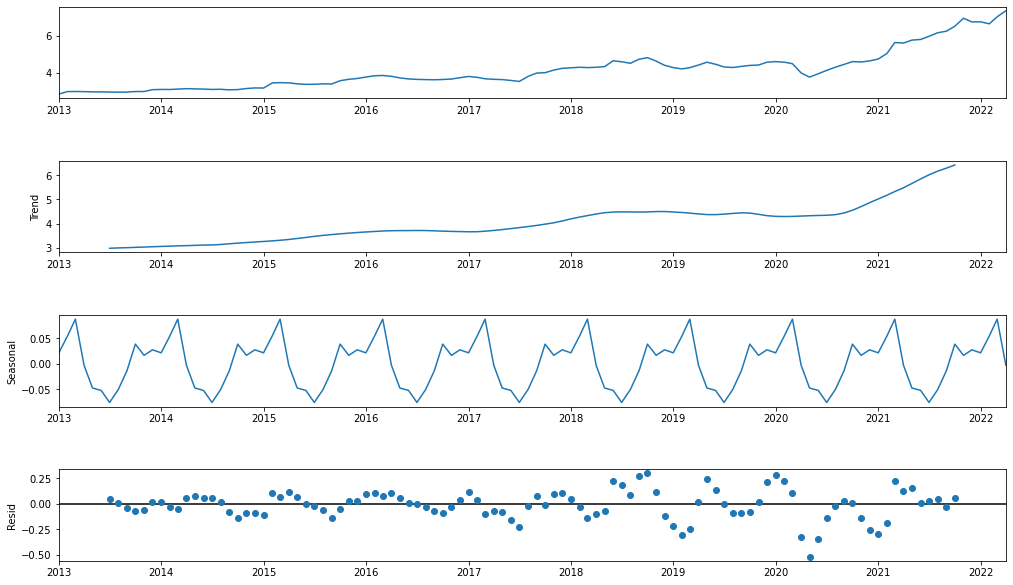

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose
nresult = seasonal_decompose(data, model='additive')
fig = nresult.plot()
fig.set_size_inches((16, 9))


In [12]:
from statsmodels.tsa.stattools import adfuller

fuller_test = adfuller(train_set)
fuller_test

(0.43113811236298816,
 0.9826227828316483,
 1,
 103,
 {'1%': -3.4954932834550623,
  '5%': -2.8900369024285117,
  '10%': -2.5819706975209726},
 -115.74635796650517)

pValue (0.7123208502418145) > 0.01, - aceita-se H0
portanto a série NÃO é estacionária

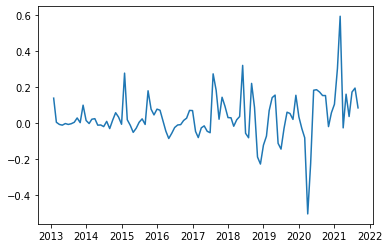

In [13]:
data_diff = train_set.diff(periods=1)
data_diff.drop(index=data_diff.index[0], axis=0, inplace=True)
plt.plot(data_diff)
plt.show()

# Uma diferenciação é necessária para tornar a série estaciónaria.

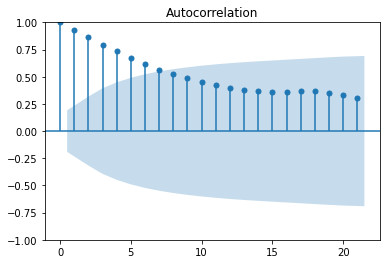

In [14]:
plot_acf(train_set)
plt.show()

c:\Users\Gabriel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


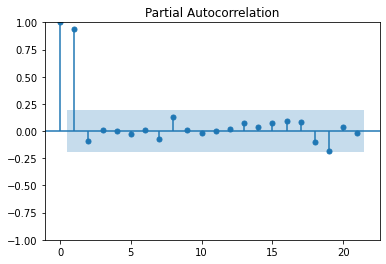

In [15]:
plot_pacf(train_set)
plt.show()

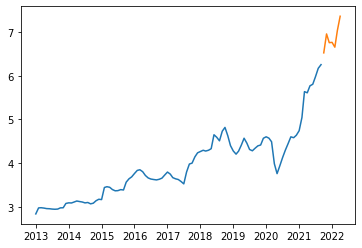

In [16]:
plt.plot(train_set.index, train_set)
plt.plot(test_set.index, test_set)
plt.show()

In [33]:
from pmdarima.arima import auto_arima

model = auto_arima(train_set)

In [34]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  464
Model:               SARIMAX(1, 2, 2)   Log Likelihood                 896.816
Date:                Wed, 15 Jun 2022   AIC                          -1785.632
Time:                        19:18:35   BIC                          -1769.090
Sample:                             0   HQIC                         -1779.119
                                - 464                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6629      0.065     10.168      0.000       0.535       0.791
ma.L1         -1.2430      0.073    -16.991      0.000      -1.386      -1.100
ma.L2          0.2548      0.066      3.841      0.000       0.125       0.385
sigma2         0.0012   2.54e-05     47.322      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              6299.02
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               2.49   Skew:                             2.37
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [73]:
from pmdarima.arima import auto_arima
model = auto_arima(train_set, X=exog_train, suppress_warnings=True)


In [46]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  464
Model:               SARIMAX(1, 2, 2)   Log Likelihood                 896.942
Date:                Wed, 15 Jun 2022   AIC                          -1783.883
Time:                        19:37:56   BIC                          -1763.206
Sample:                             0   HQIC                         -1775.742
                                - 464                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0003      0.001      0.477      0.633      -0.001       0.002
ar.L1          0.6575      0.068      9.737      0.000       0.525       0.790
ma.L1         -1.2373      0.076    -16.354      0.000      -1.386      -1.089
ma.L2          0.2495      0.068      3.654      0.000       0.116       0.383
sigma2         0.0012   3.04e-05     39.482      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              6129.23
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               2.53   Skew:                             2.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [66]:
exog_train = exog[:-36].values.reshape(-1,1)
exog_test = exog[-36:].values.reshape(-1,1)

In [44]:
exog_train

array([[111.31],
       [110.64],
       [111.89],
       [113.28],
       [116.76],
       [118.9 ],
       [117.66],
       [114.1 ],
       [110.4 ],
       [110.85],
       [109.82],
       [107.66],
       [110.02],
       [104.12],
       [103.11],
       [ 99.65],
       [103.16],
       [104.19],
       [103.91],
       [104.64],
       [102.64],
       [100.39],
       [104.56],
       [105.93],
       [100.91],
       [102.16],
       [107.72],
       [108.81],
       [108.07],
       [107.17],
       [108.95],
       [108.22],
       [110.4 ],
       [111.04],
       [114.01],
       [116.12],
       [112.78],
       [109.22],
       [108.63],
       [109.46],
       [111.28],
       [109.94],
       [106.93],
       [105.91],
       [105.12],
       [108.5 ],
       [111.05],
       [109.69],
       [111.61],
       [108.83],
       [111.77],
       [112.18],
       [106.89],
       [107.25],
       [106.48],
       [107.88],
       [106.4 ],
       [109.57],
       [109.08

In [29]:
train_set.shape

(464,)

In [74]:
out = np.concatenate([model.predict_in_sample(X=exog_train), model.predict(n_periods=36, X=exog_test)])

In [75]:
data_aux = pd.DataFrame({'date': date_range, 'out': out })
resultado_final = create_time_series(data_aux, start_date, end_date, var='out', freq=pd.offsets.Week(1))

In [51]:
fitted = model.predict_in_sample(X=exog_train)
previsao = model.predict(n_periods=24, X=exog_test)

In [57]:
data_aux

,date,out
0,2012-12-30,0.033097
1,2013-01-06,4.076752
2,2013-01-13,2.745571
3,2013-01-20,2.718671
4,2013-01-27,2.736041
...,...,...
483,2022-04-03,7.246632
484,2022-04-10,7.276500
485,2022-04-17,7.302215
486,2022-04-24,7.330231


In [9]:
plt.figure(figsize=(18,8))
plt.plot(resultado_final)
plt.plot(time_series)
plt.show()


NameError: name 'resultado_final' is not defined

<Figure size 1296x576 with 0 Axes>

In [19]:
preds, conf_int = model.predict(n_periods=test_set.shape[0], return_conf_int=True)

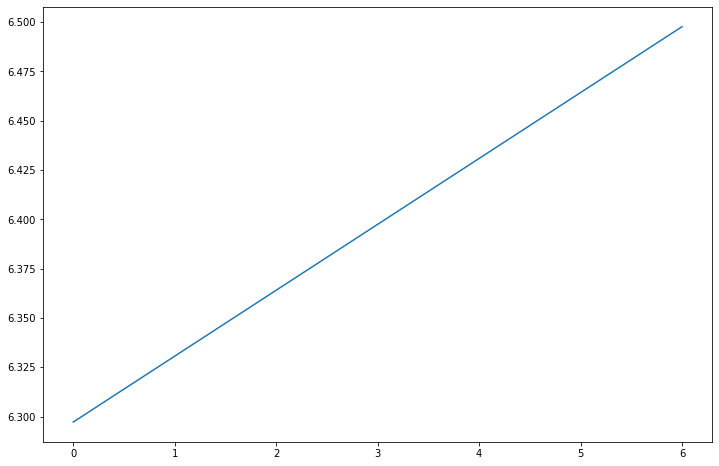

In [27]:
plt.figure(figsize=(12,8))
plt.plot(preds)
plt.show()

In [21]:
len(covid[:train_size])
len(test_set)

7

In [22]:
from statsmodels.tsa.arima.model import ARIMA
 
arima = ARIMA(train_set, freq="MS", order=(0,1,1),exog ).fit()
arima_train_result = arima.predict()

In [23]:
arima_test = ARIMA(test_set, freq="MS", exog=covid[train_size:], order=(0,1,1)).fit(arima.params)
arima_result = arima_test.predict()

In [24]:
arima_final = ARIMA(data, freq="MS", exog=covid, order=(0,1,1)).fit(arima.params)
arima_final_result = arima_final.predict(steps=6, exog=[[0,0,0,0,0,0]])

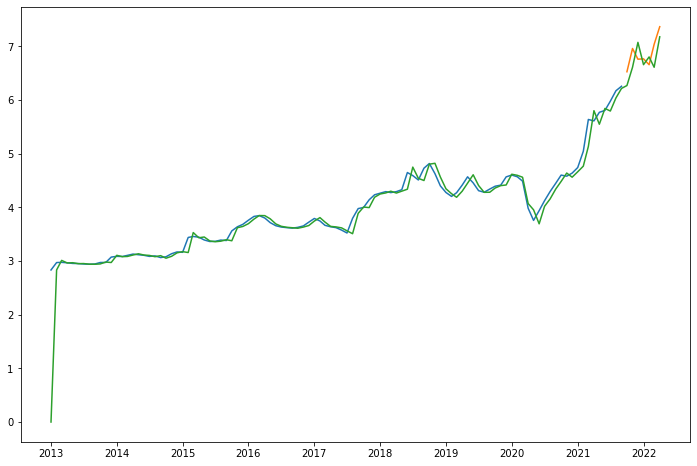

In [25]:
plt.figure(figsize=(12,8))
plt.plot(train_set)
plt.plot(test_set)
plt.plot(arima_final_result)
plt.show()

In [51]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

test_set =test_set[1:]
arima_result = arima_result[1:]
mape = mean_absolute_percentage_error(test_set, arima_result)
mape

2.9139858699900527

In [52]:
from sklearn.metrics import mean_squared_error

print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test_set, arima_result)))

Test RMSE: 0.200


In [56]:
from statsmodels.stats.diagnostic import acorr_ljungbox

##  Residuos não sao auto-correlacionados
acorr_ljungbox(arima_test.resid[1:], lags=[12], return_df=True)

,lb_stat,lb_pvalue
12,14.434743,0.273812


In [57]:
from statsmodels.stats.diagnostic import kstest_normal,het_arch
# 2. Normalidade dos resíduos

# p-valor =  0.0009999999999998899 < 0,01 - Rejeita-se H0, ou seja, resíduos não são normais
kstest_normal(arima_test.resid[1:], dist='norm')


(0.07940657684056818, 0.80168250410451)

In [58]:
from statsmodels.stats.diagnostic import het_arch

##  0.27682059406368875 > 0.01, Aceita-se H0, não se rejeita a H0, garante a não existencia de efeitos ARCH
#   Logo, a variância está estabilizada.
het_arch(arima_test.resid[1:])

(1.8638868188302748,
 0.9669882224465045,
 0.20819968857526724,
 0.9799463775404086)

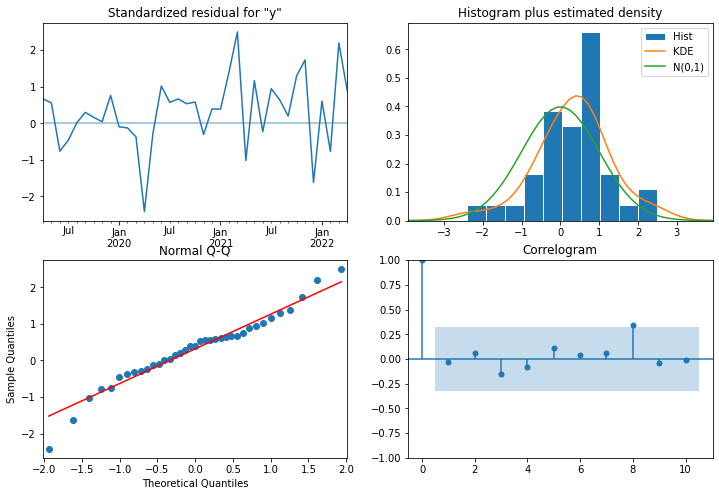

In [34]:
arima_test.plot_diagnostics(figsize=(12,8))
plt.show()